In [1]:
import numpy as np
import pandas as pd 

In [2]:
import glob

tables = {
    'orders': '/kaggle/input/test-recsys/kaggle_tab_1345/tab_1_orders.csv',
    'products': list(sorted(glob.glob('/kaggle/input/test-recsys/sbermarket_tab_2*/*'))),
    'categories': '/kaggle/input/test-recsys/kaggle_tab_1345/tab_3_categories.csv',
    'users': '/kaggle/input/test-recsys/kaggle_tab_1345/tab_4_user_profiles.csv',
    'product_properties': '/kaggle/input/test-recsys/kaggle_tab_1345/tab_5_product_properties.csv',
    'cities': '/kaggle/input/test-recsys/tab_6_city.csv',
    'sample_submission': '/kaggle/input/test-recsys/sample_submission.csv',
}


In [3]:
products = pd.concat(list(map(lambda x: pd.read_csv(x, usecols=['user_id','order_id', 'price', 'quantity', 'discount', 'product_id']), tables['products'])))

# Сhoose top products for future model based on CF, top 30 for each user and top 50 of full dataset

In [4]:
top_products = pd.read_csv('/kaggle/input/top-products2/user_top_products (2).csv')

In [5]:
top_products.product_id = top_products.product_id.apply(lambda x: set(x.split(' ')))
top_products.head()

,user_id,product_id
0,51,"{3817538, 2600, 93825, 57398, 84364, 27471, 35..."
1,65,"{201286, 12792, 18450, 5479458, 2589313, 28334..."
2,83,"{27613, 10090, 5062928, 9714, 59094, 198543, 3..."
3,142,{5051530}
4,187,"{88084, 88086}"


In [6]:
import itertools
def get_top_data(top_products, k=30):
    'get top k data'
    top = []
    for i in top_products.product_id:
        top.append(list(i)[:k])
    merged = list(itertools.chain(*top))
    merged = [int(i) for i in merged]
    return merged

In [7]:
# choose top data based on dataset popularity and predictions
top_data = get_top_data(top_products)
top_from_dataset = list(products['product_id'].value_counts().index)[:50]

In [8]:
choosen_top_data = list(set(top_from_dataset + top_data))

We can use this product_id for our future predictions

# Preprocessing features for user

In [22]:
from tqdm import tqdm
def create_user_dataset(debug):
#     calculate num of orders for each user
    num_of_orders = debug.groupby(['user_id'])['order_id'].nunique().values
    users = list(debug.groupby(['user_id'])['order_id'].nunique().index)
    debug['num_of_orders'] = debug['user_id']
    debug.num_of_orders = debug.num_of_orders.map(dict(zip(users, num_of_orders)))
    # for each user get products diversity and num_of_products
    diverse = list(debug.groupby(['user_id'])['product_id'].nunique().values)
    purchase = list(debug.groupby(['user_id'])['product_id'].count().values)## 
#     spend_money = debug.groupby(['user_id'])['price'].sum().values #todo
#     add avg check from another table
#    add avg items in check from another table

    d = {'user_id':users, 'num_of_orders': num_of_orders, 'diverse_products' : diverse, 'full_purchases': purchase}
    # full_purchases -- total number of purchases
    # money_spend -- all money spend 
    user_info = pd.DataFrame(data=d)
    return user_info

In [23]:
user_info = create_user_dataset(products)

In [24]:
user_info.head()

,user_id,num_of_orders,diverse_products,full_purchases
0,51,17,501,832
1,65,23,176,840
2,83,1,33,34
3,142,1,1,1
4,187,1,2,2


Add user features from dataset created in other notebook

In [25]:
additional_features = pd.read_csv('/kaggle/input/users-new-info/tickets_means.csv')

In [26]:
additional_features.head()

,user_id,price,amount
0,51,17875.070558,48.941176
1,65,7872.709124,36.521739
2,83,5894.309998,34.000000
3,142,3781.000000,1.000000
4,187,554.220001,2.000000


In [27]:
user_info['avg_check'] = additional_features['price']
user_info['avg_items_in_check'] = additional_features['amount']

In [28]:
user_info.head()

,user_id,num_of_orders,diverse_products,full_purchases,avg_check,avg_items_in_check
0,51,17,501,832,17875.070558,48.941176
1,65,23,176,840,7872.709124,36.521739
2,83,1,33,34,5894.309998,34.000000
3,142,1,1,1,3781.000000,1.000000
4,187,1,2,2,554.220001,2.000000


# Clusterize users into groups

100%|██████████| 19/19 [05:15<00:00, 16.61s/it]


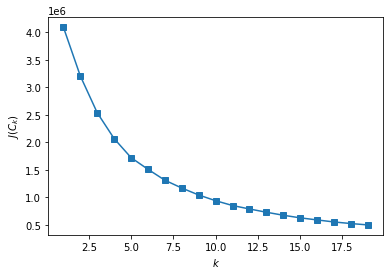

In [29]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
inertia = []
for k in tqdm(range(1, 20)):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(user_info[user_info.columns[1:]])
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 20), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [30]:
cluster_labels = kmeans.labels_

In [31]:
dict(zip(user_info.user_id.values, cluster_labels))

{51: 12,
 65: 15,
 83: 5,
 142: 0,
 187: 7,
 223: 14,
 224: 15,
 260: 0,
 336: 5,
 353: 5,
 359: 0,
 400: 11,
 433: 0,
 516: 16,
 525: 11,
 547: 14,
 553: 7,
 576: 0,
 608: 0,
 623: 5,
 640: 15,
 725: 16,
 761: 2,
 766: 0,
 770: 2,
 780: 15,
 820: 12,
 821: 2,
 825: 11,
 834: 12,
 840: 2,
 859: 5,
 884: 14,
 903: 5,
 905: 2,
 927: 5,
 932: 16,
 992: 7,
 1003: 11,
 1007: 0,
 1012: 11,
 1019: 11,
 1023: 0,
 1025: 5,
 1027: 16,
 1050: 15,
 1081: 5,
 1107: 0,
 1131: 15,
 1132: 5,
 1139: 7,
 1154: 5,
 1177: 0,
 1195: 2,
 1215: 14,
 1221: 5,
 1331: 0,
 1359: 16,
 1360: 14,
 1368: 5,
 1371: 16,
 1378: 11,
 1408: 15,
 1436: 5,
 1474: 14,
 1559: 5,
 1562: 15,
 1578: 2,
 1608: 11,
 1625: 5,
 1626: 11,
 1646: 16,
 1647: 16,
 1705: 7,
 1719: 7,
 1724: 15,
 1736: 14,
 1768: 14,
 1781: 0,
 1789: 0,
 1790: 11,
 1816: 0,
 2043: 0,
 2066: 15,
 2073: 15,
 2075: 11,
 2083: 2,
 2095: 0,
 2098: 14,
 2122: 12,
 2129: 16,
 2131: 5,
 2146: 0,
 2158: 16,
 2171: 5,
 2203: 11,
 2268: 15,
 2283: 15,
 2293: 5,
 23

# Add info on gender


In [16]:
users = pd.read_csv('/kaggle/input/test-recsys/kaggle_tab_1345/tab_4_user_profiles.csv')

In [17]:
users.gender = users.gender.map({'male':1, 'female':2})
users.gender = users.gender.replace(np.nan, 0)
gender_map = dict(zip(list(users.user_id.values),list(users.gender.values)))

In [18]:
user_info['gender'] = user_info['user_id']
user_info['gender'] = user_info['gender'].map(gender_map)

In [19]:
user_info['gender'] = user_info['gender'].map(gender_map)

# Merge order and city tables

In [32]:
orders = pd.read_csv('/kaggle/input/test-recsys/kaggle_tab_1345/tab_1_orders.csv')
city = pd.read_csv('/kaggle/input/test-recsys/tab_6_city.csv')
ord_city = orders.merge(city, how='left')

In [33]:
map_platform = {'web':0,
               'app':1,
               'undefined':2}

ord_city['platform'] = ord_city.platform.map(map_platform)

In [34]:
from datetime import datetime
from tqdm import tqdm
hour, day, month, year = [],[],[],[]
for i in tqdm(range(ord_city.shape[0])):
    d1 = datetime.strptime(ord_city['order_created_time'].iloc[i], "%Y-%m-%d %H:%M:%S")
    hour.append(d1.hour)
    day.append(d1.day)
    month.append(d1.month)
    year.append(d1.year)

100%|██████████| 2461958/2461958 [01:31<00:00, 26781.49it/s]


In [35]:
ord_city['hour'] = hour
ord_city['month'] = month
ord_city['day'] = day
# ord_city['year'] = year
ord_city.drop('order_created_time', inplace=True, axis=1)

In [36]:
# map top 5 cities, others - other
cities = list(ord_city.city_name.value_counts().index)
changed_cities = cities[:5]+['other']*(len(cities)-5)
map_cities = dict(zip(cities, changed_cities))
ord_city.city_name = ord_city.city_name.map(map_cities)
map_city = {'other':0,
           'Москва':1,
           'Санкт-Петербург':2,
           'Новосибирск':3,
           'Краснодар':4,
           'Московская Область':5}
ord_city.city_name = ord_city.city_name.map(map_city)

In [37]:
drop_column = ['store_id', 'retailer']
ord_city.drop(drop_column, axis=1, inplace=True)

In [38]:
ord_city.head()

,user_id,order_id,platform,city_name,hour,month,day
0,72,17431000,1,1,10,9,26
1,83,9718154,0,5,9,5,8
2,142,10056850,1,5,15,5,14
3,187,15952443,1,1,17,9,1
4,224,10409918,0,1,6,5,20
